# 中文CLIP分类

In [1]:
from PIL import Image
import requests
import clip
import torch
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from transformers import CLIPProcessor, CLIPModel
import numpy as np

/root/miniconda3/envs/llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 更改huggingface的缓存默认目录
import os
os.environ['HF_HOME'] = '/root/autodl-tmp/cache/'
os.environ['TRANSFORMERS_OFFLINE'] = '0' 

In [3]:
print(os.environ['HF_HOME'])

/root/autodl-tmp/cache/


In [4]:
# 学术加速
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [5]:
text_tokenizer = BertTokenizer.from_pretrained("IDEA-CCNL/Taiyi-CLIP-Roberta-large-326M-Chinese")
text_encoder = BertForSequenceClassification.from_pretrained("IDEA-CCNL/Taiyi-CLIP-Roberta-large-326M-Chinese").eval()

/root/miniconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/root/miniconda3/envs/llava/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:
target_classes = ["T恤", "不是T恤"]

In [7]:
text_inputs = text_tokenizer(["T恤"], return_tensors='pt', padding=True)['input_ids']

In [8]:
"""参考DatasetFolder类源码：
https://pytorch.org/vision/stable/generated/torchvision.datasets.DatasetFolder.html#torchvision.datasets.DatasetFolder"""
from torchvision.datasets import VisionDataset
from PIL import Image
from typing import List, Tuple, Dict, Union, Optional, Callable, Any, cast
from pathlib import Path

IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp")

def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")

def default_loader(path: str) -> Any:
    from torchvision import get_image_backend

    if get_image_backend() == "accimage":
        return accimage_loader(path)
    else:
        return pil_loader(path)

def has_file_allowed_extension(filename: str, extensions: Union[str, Tuple[str, ...]]) -> bool:
    """Checks if a file is an allowed extension.

    Args:
        filename (string): path to a file
        extensions (tuple of strings): extensions to consider (lowercase)

    Returns:
        bool: True if the filename ends with one of given extensions
    """
    return filename.lower().endswith(extensions if isinstance(extensions, str) else tuple(extensions))

class CustomDataset(VisionDataset):
    def __init__(
        self,
        root: Union[str, Path],
        loader: Callable[[str], Any] = default_loader,
        extensions: Optional[Tuple[str, ...]] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        is_valid_file: Optional[Callable[[str], bool]] = None,
        allow_empty: bool = False,
        # 目标类别
        target_classes: List[str] = None,
        **kwargs
    ):
        super().__init__(root, transform=transform, target_transform=target_transform)
        original_classes, original_class_to_idx = self.find_classes(self.root)
        target_class_to_idx = {cls_name: i for i, cls_name in enumerate(target_classes)}
        map_class = {}
        # 5个正类加上其他
        if len(target_classes) == 6:
            for target_class in target_classes:
                if target_class == "其他" or target_class == "others":
                    map_class[target_class] = ["tennis-racket", "cherry", "mantou", "dress-shirt", "violin"]
                elif target_class in ["badminton-racket", "羽毛球拍"]:
                    map_class[target_class] = ["badminton-racket"]
                elif target_class in ["lychee", "荔枝"]:
                    map_class[target_class] = ["lychee"]
                elif target_class in ["baozi", "包子"]:
                    map_class[target_class] = ["baozi"]
                elif target_class in ["T-shirt", "T恤"]:
                    map_class[target_class] = ["T-shirt"]
                elif target_class in ["guitar", "吉他"]:
                    map_class[target_class] = ["guitar"]
                else:
                    raise ValueError(f"Found no valid class {target_class}.")
        # 1个正类加上其他
        elif len(target_classes) == 2:
            for target_class in target_classes:
                if target_class in ["badminton-racket", "羽毛球拍"]:
                    map_class[target_class] = ["badminton-racket"]
                    if target_class == "badminton-racket":
                        map_class["not badminton-racket"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["badminton-racket"]]
                    else:
                        map_class["不是羽毛球拍"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["badminton-racket"]]
                elif target_class in ["lychee", "荔枝"]:
                    map_class[target_class] = ["lychee"]
                    if target_class == "lychee":
                        map_class["not lychee"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["lychee"]]
                    else:
                        map_class["不是荔枝"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["lychee"]]
                elif target_class in ["baozi", "包子"]:
                    map_class[target_class] = ["baozi"]
                    if target_class == "baozi":
                        map_class["not baozi"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["baozi"]]
                    else:
                        map_class["不是包子"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["baozi"]]
                elif target_class in ["T-shirt", "T恤"]:
                    map_class[target_class] = ["T-shirt"]
                    if target_class == "T-shirt":
                        map_class["not T-shirt"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["T-shirt"]]
                    else:
                        map_class["不是T恤"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["T-shirt"]]
                elif target_class in ["guitar", "吉他"]:
                    map_class[target_class] = ["guitar"]
                    if target_class == "guitar":
                        map_class["not guitar"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["guitar"]]
                    else:
                        map_class["不是吉他"] = [cls_name for idx, cls_name in enumerate(original_classes) if idx != original_class_to_idx["guitar"]]
        else:
            raise ValueError("Not match!")
            
        samples = self.make_dataset(
            self.root,
            target_class_to_idx,
            map_class,
            extensions=IMG_EXTENSIONS,
            is_valid_file=is_valid_file,
            allow_empty=allow_empty,
        )
        
        self.loader = loader
        self.extensions = extensions

        self.classes = target_classes
        self.class_to_idx = target_class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]
        
    @staticmethod    
    def make_dataset(
        directory: Union[str, Path],
        class_to_idx: Dict[str, int],
        map_class: Optional[Dict[str, str]] = None,
        extensions: Optional[Tuple[str, ...]] = None,
        is_valid_file: Optional[Callable[[str], bool]] = None,
        allow_empty: bool = False,
    ) -> List[Tuple[str, int]]:
        """
        重写 make_dataset，处理合并后的标签逻辑
        """
        directory = os.path.expanduser(directory)

        if class_to_idx is None:
            _, class_to_idx = find_classes(directory)
        elif not class_to_idx:
            raise ValueError("'class_to_index' must have at least one entry to collect any samples.")

        both_none = extensions is None and is_valid_file is None
        both_something = extensions is not None and is_valid_file is not None
        if both_none or both_something:
            raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")

        if extensions is not None:

            def is_valid_file(x: str) -> bool:
                return has_file_allowed_extension(x, extensions)  # type: ignore[arg-type]

        is_valid_file = cast(Callable[[str], bool], is_valid_file)

        instances = []
        available_classes = set()
        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            for path_name in map_class[target_class]:
                target_dir = os.path.join(directory, path_name)
                if not os.path.isdir(target_dir):
                    continue
                for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                    for fname in sorted(fnames):
                        path = os.path.join(root, fname)
                        if is_valid_file(path):
                            item = path, class_index
                            instances.append(item)

                            if target_class not in available_classes:
                                available_classes.add(target_class)
        empty_classes = set(class_to_idx.keys()) - available_classes
        if empty_classes and not allow_empty:
            msg = f"Found no valid file for the classes {', '.join(sorted(empty_classes))}. "
            if extensions is not None:
                msg += f"Supported extensions are: {extensions if isinstance(extensions, str) else ', '.join(extensions)}"
            raise FileNotFoundError(msg)

        return instances
        
    def find_classes(self, directory: Union[str, Path]) -> List[str]:
        """Find the class folders in a dataset structured as follows::

            directory/
            ├── class_x
            │   ├── xxx.ext
            │   ├── xxy.ext
            │   └── ...
            │       └── xxz.ext
            └── class_y
                ├── 123.ext
                ├── nsdf3.ext
                └── ...
                └── asd932_.ext

        This method can be overridden to only consider
        a subset of classes, or to adapt to a different dataset directory structure.

        Args:
            directory(str): Root directory path, corresponding to ``self.root``

        Raises:
            FileNotFoundError: If ``dir`` has no class folders.

        Returns:
            (Tuple[List[str], Dict[str, int]]): List of all classes and dictionary mapping each class to an index.
        """
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")
            
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
    
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.samples)


In [9]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

In [10]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=processor.image_processor,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)  

['T恤', '不是T恤']
{'T恤': 0, '不是T恤': 1}


In [11]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14") 

In [12]:
clip_model = clip_model.to("cuda")
text_inputs = text_inputs.to("cuda")
text_encoder = text_encoder.to("cuda")

In [13]:
def eval_threshold(pos_res, neg_res, threshold):
    pos_res = np.array(pos_res)
    neg_res = np.array(neg_res)
    # 计算tp,fp,fn 这里注意后面的分母是不是会出现nan或者0
    tp = sum(pos_res >= threshold)
    fp = sum(neg_res >= threshold)
    fn = sum(pos_res < threshold)

    # precision = TP / TP + FP
    precision = tp / (tp + fp)

    # recall = TP / TP + FN
    recall = tp / (tp + fn)

    # f1-score = 2 * precision * recall / (precision + recall )
    f1_score = 2 * precision * recall / (precision + recall)

    return f1_score, precision, recall

In [14]:
def find_thresholds(pos_res, neg_res, target_classes):
    thresholds = np.linspace(min(min(pos_res), min(neg_res)), max(max(pos_res), max(neg_res)), 200)

    best_threshold = 0.
    best_f1_score = 0.
    best_precision = 0.
    best_recall = 0.
    f1_scores = []

    for threshold in thresholds:
        f1_score, precision, recall = eval_threshold(pos_res, neg_res, threshold)
        f1_scores.append(f1_score)

        # 判断最佳f1
        if f1_score > best_f1_score:
            # 更新指标
            best_threshold = threshold
            best_f1_score = f1_score
            best_precision = precision
            best_recall = recall

    print(f"{target_classes[0]}_best_threshold", best_threshold)
    print(f"{target_classes[0]}_best_f1_score", best_f1_score)
    print(f"{target_classes[0]}_best_precision", best_precision)
    print(f"{target_classes[0]}_best_recall", best_recall)

    import matplotlib.pyplot as plt
    # print(thresholds)
    # print(f1_scores)
    # 绘制曲线
    plt.figure(figsize=(9, 9))
    plt.plot(thresholds, f1_scores)
    # 绘制最佳点
    plt.scatter(x=best_threshold, y=best_f1_score)
    plt.annotate(f"threshold:{best_threshold:.5f}/f1:{best_f1_score:.5f}", xy=(best_threshold, best_f1_score))
    # 添加文字信息
    plt.xlabel('threshold')
    plt.ylabel('f1_score')
    plt.title(f'{target_classes[0]}_precision:{best_precision:.4f}_recall:{best_recall:.4f}')
    plt.savefig(f'result_{target_classes[0]}_all.jpg')

    print('done')

In [15]:
def get_similarity(test_loader, text_inputs, threshold, device="cuda"):
    pos_res = []
    neg_res = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images['pixel_values'][0].to(device)

            # 计算图像特征
            image_features = clip_model.get_image_features(pixel_values=images)
            # 计算文本特征
            text_features = text_encoder(text_inputs).logits
            # 归一化
            image_features = image_features / image_features.norm(dim=1, keepdim=True)
            text_features = text_features / text_features.norm(dim=1, keepdim=True)
            # 计算余弦相似度 logit_scale是尺度系数
            logit_scale = clip_model.logit_scale.exp()
            similarity = logit_scale * torch.nn.functional.cosine_similarity(image_features, text_features)
            pos_mask = (labels == 0)  # 正类掩码（标签为0）
            neg_mask = (labels == 1)  # 负类掩码（标签为1）

            pos_res.extend(similarity.cpu().numpy()[pos_mask])
            neg_res.extend(similarity.cpu().numpy()[neg_mask])
    return pos_res, neg_res
            

In [16]:
from torch.utils.data import DataLoader
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [41]:
pos_res, neg_res = get_similarity(test_loader, text_inputs, threshold=0.09)

/root/miniconda3/envs/llava/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:900: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/root/miniconda3/envs/llava/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/miniconda3/envs/llava/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/miniconda3/envs/llava/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/root/miniconda3/envs/llava/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


荔枝_best_threshold 10.377091302344546
荔枝_best_f1_score 1.0
荔枝_best_precision 1.0
荔枝_best_recall 1.0
done


/tmp/ipykernel_19335/2260241958.py:40: UserWarning: Glyph 33620 (\N{CJK UNIFIED IDEOGRAPH-8354}) missing from font(s) DejaVu Sans.
  plt.savefig(f'result_{target_classes[0]}_all.jpg')
/tmp/ipykernel_19335/2260241958.py:40: UserWarning: Glyph 26525 (\N{CJK UNIFIED IDEOGRAPH-679D}) missing from font(s) DejaVu Sans.
  plt.savefig(f'result_{target_classes[0]}_all.jpg')
/root/miniconda3/envs/llava/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 33620 (\N{CJK UNIFIED IDEOGRAPH-8354}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/root/miniconda3/envs/llava/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26525 (\N{CJK UNIFIED IDEOGRAPH-679D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


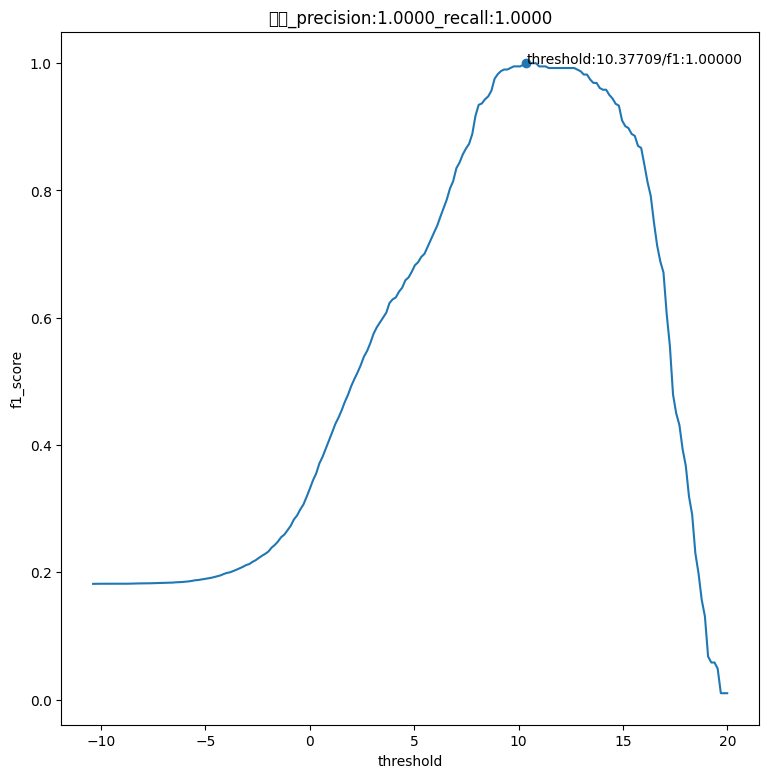

In [42]:
find_thresholds(pos_res, neg_res, target_classes)

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
classification_report(all_labels, all_preds, target_names=target_classes)

In [19]:
text_inputs = text_tokenizer(["吉他"], return_tensors='pt', padding=True)['input_ids'].to("cuda")

In [20]:
target_classes = ["吉他", "不是吉他"]

In [21]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=processor.image_processor,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)  

['吉他', '不是吉他']
{'吉他': 0, '不是吉他': 1}


In [22]:
from torch.utils.data import DataLoader
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
all_preds, all_labels = zeroshot_classifier_threshold(test_loader, text_inputs, threshold=0.11)

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
classification_report(all_labels, all_preds, target_names=target_classes)

In [25]:
text_inputs = text_tokenizer(["羽毛球拍"], return_tensors='pt', padding=True)['input_ids'].to("cuda")

In [26]:
target_classes = ["羽毛球拍", "不是羽毛球拍"]

In [27]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=processor.image_processor,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx)  

['羽毛球拍', '不是羽毛球拍']
{'羽毛球拍': 0, '不是羽毛球拍': 1}


In [28]:
from torch.utils.data import DataLoader
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
all_preds, all_labels = zeroshot_classifier_threshold(test_loader, text_inputs, threshold=0.16)

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
classification_report(all_labels, all_preds, target_names=target_classes)

In [31]:
text_inputs = text_tokenizer(["包子"], return_tensors='pt', padding=True)['input_ids'].to("cuda")

In [32]:
target_classes = ["包子", "不是包子"]

In [33]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=processor.image_processor,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx) 

['包子', '不是包子']
{'包子': 0, '不是包子': 1}


In [34]:
from torch.utils.data import DataLoader
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
all_preds, all_labels = zeroshot_classifier_threshold(test_loader, text_inputs, threshold=0.14)

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
classification_report(all_labels, all_preds, target_names=target_classes)

In [37]:
text_inputs = text_tokenizer(["荔枝"], return_tensors='pt', padding=True)['input_ids'].to("cuda")

In [38]:
target_classes = ["荔枝", "不是荔枝"]

In [39]:
dataset = CustomDataset(
    root="/root/autodl-tmp/Image-Downloader/images/",
    transform=processor.image_processor,
    target_classes=target_classes,
)

# 输出类别映射
print(dataset.classes)  
print(dataset.class_to_idx) 

['荔枝', '不是荔枝']
{'荔枝': 0, '不是荔枝': 1}


In [40]:
from torch.utils.data import DataLoader
# 创建DataLoader（按需调整batch_size和num_workers）
test_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
all_preds, all_labels = zeroshot_classifier_threshold(test_loader, text_inputs, threshold=0.1)

In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
classification_report(all_labels, all_preds, target_names=target_classes)